# Overview: Estimators and Estimator Results API

This notebooks provides an overview of the `Estimator` API in Gammapy. All estimators live in the `gammapy.estimators` sub-package and provide common functionality such as estimation of flux points, lightcurves, flux maps and profiles via a common API.

The API was finalised with v0.19, however it is not fully documented yet, so we take the chance and demo it at this user call.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from astropy import units as u
from astropy.coordinates import SkyCoord

In [3]:
from gammapy.datasets import MapDataset, SpectrumDatasetOnOff, Datasets
from gammapy.estimators import (
    FluxPointsEstimator,
    FluxProfileEstimator,
    TSMapEstimator,
)
from gammapy.modeling import Fit
from gammapy.modeling.models import SkyModel, PowerLawSpectralModel, PointSpatialModel
from gammapy.utils.scripts import make_path
from gammapy.utils.regions import make_orthogonal_rectangle_sky_regions
from gammapy.maps import RegionGeom

## Example 1: Flux Points Estimation

We start with a simple example for flux points estimation taking multiple datasets into account. First we read the pre-computed datasets from `GAMMAPY_DATA`:

### Data Reading and Fit

In [4]:
datasets = Datasets()

path = make_path("$GAMMAPY_DATA/joint-crab/spectra/hess/")

for filename in path.glob("pha_obs*.fits"):
    dataset = SpectrumDatasetOnOff.read(filename)
    datasets.append(dataset)

Let us print the datasets to see what they contain:

In [5]:
print(datasets)

Datasets
--------

Dataset 0: 

  Type       : SpectrumDatasetOnOff
  Name       : 23559
  Instrument : 
  Models     : 

Dataset 1: 

  Type       : SpectrumDatasetOnOff
  Name       : 23523
  Instrument : 
  Models     : 

Dataset 2: 

  Type       : SpectrumDatasetOnOff
  Name       : 23592
  Instrument : 
  Models     : 

Dataset 3: 

  Type       : SpectrumDatasetOnOff
  Name       : 23526
  Instrument : 
  Models     : 




Next we define a spectral model and set it on the datasets:

In [6]:
pwl = PowerLawSpectralModel(index=2.7, amplitude='5e-11  cm-2 s-1 TeV-1')

datasets.models = SkyModel(spectral_model=pwl, name="crab")

And optimize the model parameters to best fit the data:

In [7]:
fit = Fit()
fit_result = fit.optimize(datasets=datasets)
print(fit_result)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 37
	total stat : 156.99




### Default Flux Points Estimation

Now we prepare the flux point estimation:

In [8]:
energy_edges = np.geomspace(0.7, 100, 9) * u.TeV

sed_estimator = FluxPointsEstimator(
    source="crab", energy_edges=energy_edges,
)

In [9]:
%%time
sed_result = sed_estimator.run(datasets=datasets)

CPU times: user 974 ms, sys: 27.1 ms, total: 1 s
Wall time: 1.03 s


### Accessing and Visualising Results

In [10]:
print(sed_result)

FluxPoints
----------

  geom                   : RegionGeom
  axes                   : ['lon', 'lat', 'energy']
  shape                  : (1, 1, 8)
  quantities             : ['norm', 'norm_err', 'ts', 'npred', 'npred_excess', 'stat', 'counts', 'success']
  ref. model             : pl
  n_sigma                : 1
  n_sigma_ul             : 2
  sqrt_ts_threshold_ul   : 2
  sed type init          : likelihood



We can spcify the SED type to plot:

<AxesSubplot:xlabel='Energy [keV]', ylabel='dnde (1 / (cm2 s TeV))'>

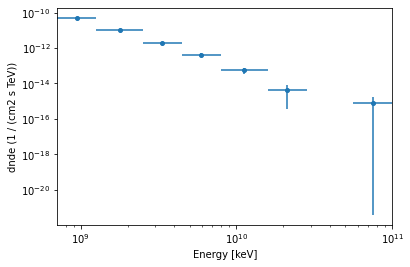

In [11]:
sed_result.plot(sed_type="dnde")

<AxesSubplot:xlabel='Energy [keV]', ylabel='e2dnde (erg / (cm2 s))'>

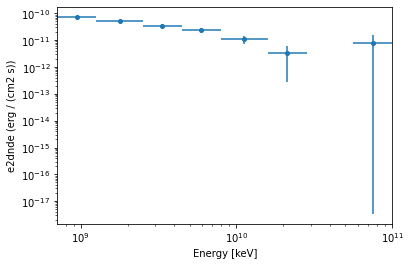

In [12]:
sed_result.plot(sed_type="e2dnde")

The actual data members are N-dimensional `RegionNDMap` objects:

In [13]:
type(sed_result.dnde)

gammapy.maps.region.ndmap.RegionNDMap

So you can plot them:

<AxesSubplot:xlabel='Energy [keV]', ylabel='$\\mathrm{TeV^{-1}\\,s^{-1}\\,cm^{-2}}$'>

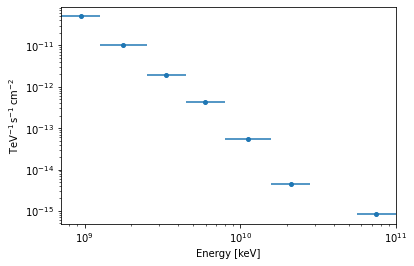

In [14]:
sed_result.dnde.plot()

Access the data:

In [15]:
sed_result.e2dnde.quantity.to("TeV cm-2 s-1")

<Quantity [[[4.45517415e-11]],

           [[3.25823909e-11]],

           [[2.13944023e-11]],

           [[1.51958055e-11]],

           [[6.92052435e-12]],

           [[2.03447394e-12]],

           [[           nan]],

           [[4.71387207e-12]]] TeV / (cm2 s)>

In [16]:
sed_result.dnde.quantity.shape

(8, 1, 1)

In [17]:
sed_result.dnde.quantity[:, 0, 0]

<Quantity [4.99878762e-11, 1.03034567e-11, 1.90677811e-12, 4.28275990e-13,
           5.49716789e-14, 4.55461982e-15,            nan, 8.38258165e-16] 1 / (cm2 s TeV)>

Or extract an energy range:

In [18]:
sed_result.dnde.slice_by_idx({"energy": slice(3, 10)})

RegionNDMap

	geom  : RegionGeom 
 	axes  : ['lon', 'lat', 'energy']
	shape : (1, 1, 5)
	ndim  : 3
	unit  : 1 / (cm2 s TeV)
	dtype : float64

### A Note On the Internal Representation

The result contains a reference spectral model, which defines the speectral shape. Typically it the best fit model:

In [19]:
print(sed_result.reference_model)

SkyModel

  Name                      : ZqxMO1t5
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : 
  Temporal model type       : 
  Parameters:
    index                   :      2.700   +/-    0.00             
    amplitude               :   4.58e-11   +/- 0.0e+00 1 / (cm2 s TeV)
    reference    (frozen)   :      1.000       TeV         




Flux Points are the represented by the "norm" scaling factor with respect to the reference model:

<AxesSubplot:xlabel='Energy [keV]', ylabel='$\\mathrm{}$'>

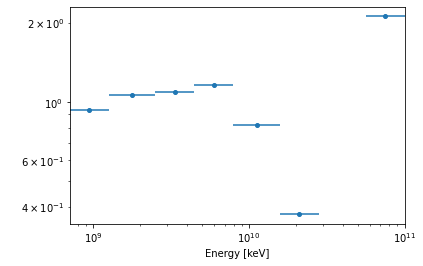

In [20]:
sed_result.norm.plot()

### Dataset Specific Quantities ("Counts Like")

While the flux estimate and associated errors are common to all datastes, the result also stores some dataset specific quantiites, which can be useful for debugging. The `RegionNDMap` allows for plotting of multidimensional data as well, by specifying the primary `axis_name`:

<AxesSubplot:xlabel='Energy [keV]', ylabel='$\\mathrm{}$'>

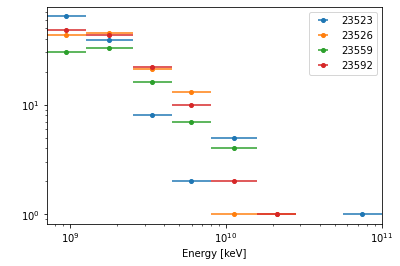

In [21]:
sed_result.counts.plot(axis_name="energy")

<AxesSubplot:xlabel='Energy [keV]', ylabel='$\\mathrm{}$'>

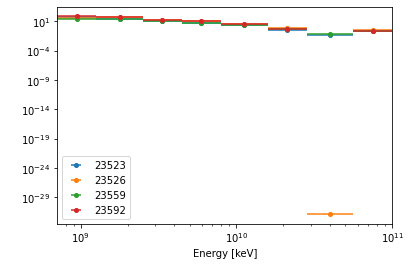

In [22]:
sed_result.npred.plot(axis_name="energy")

<AxesSubplot:xlabel='Energy [keV]', ylabel='$\\mathrm{}$'>

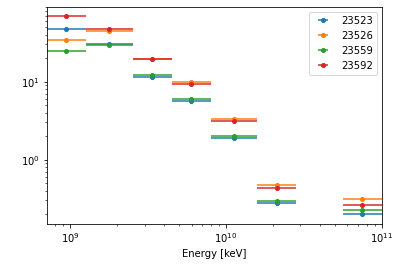

In [23]:
sed_result.npred_excess.plot(axis_name="energy")

### Table Conversion

Flux points can be converted to tables:

In [24]:
table = sed_result.to_table(sed_type="flux", format="gadf-sed")
table

e_ref,e_min,e_max,flux,flux_err,ts,sqrt_ts,npred [4],npred_excess [4],stat,is_ul,counts [4],success
keV,keV,keV,keV / (cm2 s TeV),keV / (cm2 s TeV),,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,bool,float64,bool
944060876.2859229,707945784.3841385,1258925411.7941697,0.028262201290924133,0.0022082579825766276,596.2137186003357,24.417487966626208,49.92503812882337 .. 72.39782726607214,47.13061 .. 68.50742,27.395120103750227,False,64.0 .. 48.0,True
1778279410.03893,1258925411.7941697,2511886431.509587,0.013396234895506795,0.0011199181599174976,539.6825451977705,23.23106853327609,31.42755810876801 .. 49.30449252069737,29.996315 .. 47.073925,17.974276106831102,False,39.0 .. 43.0,True
3349654391.5782814,2511886431.509587,4466835921.509632,0.0038250882377514317,0.0005036517104845425,189.21040639989505,13.755377363049515,12.1090451419453 .. 20.678634867298232,11.589506 .. 19.340569,37.72150199563111,False,8.0 .. 22.0,True
5956621435.290098,4466835921.509632,7943282347.2428255,0.0015277947990155407,0.0002825711637964068,104.69079626563644,10.231852044749104,5.864603397696946 .. 10.037264895476119,5.5708117 .. 9.307085,28.04094809317294,False,2.0 .. 10.0,True
11220184543.019672,7943282347.2428255,15848931924.611168,0.00045096081429815905,0.00015061726896045634,23.698646404065624,4.868125553441039,2.1253200810667003 .. 3.386218438883264,1.8911958 .. 3.1465917,23.18438253308521,False,5.0 .. 2.0,True
21134890398.366486,15848931924.611168,28183829312.644527,5.764921943853787e-05,5.292694389584289e-05,0.719246319521825,0.8480839106608644,0.37424598188336267 .. 0.4345174060675728,0.276685 .. 0.4345174,7.680755920947601,False,0.0 .. 1.0,True
39810717055.349655,28183829312.644527,56234132519.03493,nan,nan,-1.2351231148954867e-14,-0.0,0.04878048780487802 .. -3.0814879110195774e-33,-7.4761444e-17 .. -1.1034483e-16,0.24692612590372712,True,0.0 .. 0.0,False
74989420933.24579,56234132519.03493,100000000000.00015,3.7646022014090656e-05,3.764600558755116e-05,1.0626256422285465,1.0308373500356622,0.2000764226733665 .. 0.2643027003870023,0.20007643 .. 0.2643027,6.364518491180068,False,1.0 .. 0.0,True


In [25]:
table = sed_result.to_table(sed_type="likelihood", format="gadf-sed", formatted=True)
table

e_ref,e_min,e_max,ref_dnde,ref_flux,ref_eflux,norm,norm_err,ts,sqrt_ts,npred [4],npred_excess [4],stat,is_ul,counts [4],success
keV,keV,keV,1 / (cm2 s TeV),keV / (cm2 s TeV),keV2 / (cm2 s TeV),,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,bool,float64,bool
944060876.286,707945784.384,1258925411.794,5.349e-11,3.024e-02,2.763e+07,0.934,0.073,596.214,24.417,49.92503812882337 .. 72.39782726607214,47.13061 .. 68.50742,27.395,False,64.0 .. 48.0,True
1778279410.039,1258925411.794,2511886431.510,9.681e-12,1.259e-02,2.135e+07,1.064,0.089,539.683,23.231,31.42755810876801 .. 49.30449252069737,29.996315 .. 47.073925,17.974,False,39.0 .. 43.0,True
3349654391.578,2511886431.510,4466835921.510,1.752e-12,3.514e-03,1.139e+07,1.088,0.143,189.210,13.755,12.1090451419453 .. 20.678634867298232,11.589506 .. 19.340569,37.722,False,8.0 .. 22.0,True
5956621435.290,4466835921.510,7943282347.243,3.703e-13,1.321e-03,7.615e+06,1.156,0.214,104.691,10.232,5.864603397696946 .. 10.037264895476119,5.5708117 .. 9.307085,28.041,False,2.0 .. 10.0,True
11220184543.020,7943282347.243,15848931924.611,6.702e-14,5.498e-04,5.885e+06,0.820,0.274,23.699,4.868,2.1253200810667003 .. 3.386218438883264,1.8911958 .. 3.1465917,23.184,False,5.0 .. 2.0,True
21134890398.366,15848931924.611,28183829312.645,1.213e-14,1.535e-04,3.140e+06,0.376,0.345,0.719,0.848,0.37424598188336267 .. 0.4345174060675728,0.276685 .. 0.4345174,7.681,False,0.0 .. 1.0,True
39810717055.350,28183829312.645,56234132519.035,2.195e-15,6.389e-05,2.426e+06,nan,nan,-0.000,-0.000,0.04878048780487802 .. -3.0814879110195774e-33,-7.4761444e-17 .. -1.1034483e-16,0.247,True,0.0 .. 0.0,False
74989420933.246,56234132519.035,100000000000.000,3.972e-16,1.784e-05,1.294e+06,2.110,2.110,1.063,1.031,0.2000764226733665 .. 0.2643027003870023,0.20007643 .. 0.2643027,6.365,False,1.0 .. 0.0,True


### A Fully Configured Estimation

The follwing code shows fully configured flux points estimation:

In [26]:
fit = Fit(
    optimize_opts={"backend": "minuit"},
    confidence_opts={"backend": "scipy"},
)

sed_estimator_config = FluxPointsEstimator(
    source="crab",
    energy_edges=energy_edges,
    n_sigma=1,
    n_sigma_ul=2,
    selection_optional="all",
    norm_min=0.1,
    norm_max=20,
    norm_n_values=17,
    fit=fit,
)

In [27]:
print(sed_estimator_config)

FluxPointsEstimator
-------------------

  energy_edges           : [  0.7          1.30154979   2.42004549   4.49972813   8.36660027
  15.5564954   28.92507609  53.78203797 100.        ] TeV
  fit                    : <gammapy.modeling.fit.Fit object at 0x14386ca00>
  n_sigma                : 1
  n_sigma_ul             : 2
  norm_max               : 20
  norm_min               : 0.1
  norm_n_values          : 17
  norm_values            : None
  null_value             : 0
  reoptimize             : False
  selection_optional     : ['errn-errp', 'ul', 'scan']
  source                 : crab
  sum_over_energy_groups : False



In [28]:
%%time
sed_result_config = sed_estimator_config.run(datasets=datasets)

CPU times: user 3.16 s, sys: 34.8 ms, total: 3.2 s
Wall time: 3.26 s


In [29]:
print(sed_result_config)

FluxPoints
----------

  geom                   : RegionGeom
  axes                   : ['lon', 'lat', 'energy']
  shape                  : (1, 1, 8)
  quantities             : ['norm', 'norm_err', 'norm_errn', 'norm_errp', 'norm_ul', 'ts', 'npred', 'npred_excess', 'stat', 'counts', 'success', 'stat_scan']
  ref. model             : pl
  n_sigma                : 1
  n_sigma_ul             : 2
  sqrt_ts_threshold_ul   : 2
  sed type init          : likelihood



<AxesSubplot:xlabel='Energy [keV]', ylabel='e2dnde (erg / (cm2 s))'>

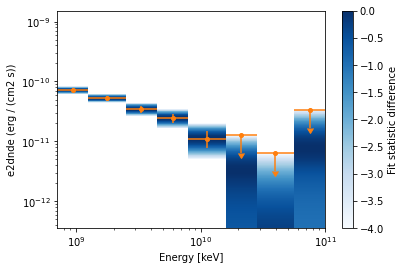

In [30]:
sed_result_config.plot(sed_type="e2dnde", color="tab:orange")
sed_result_config.plot_ts_profiles(sed_type="e2dnde")

## Example 2: Flux Map Estimation

### Data Reading

In [31]:
dataset_cta = MapDataset.read(
    "$GAMMAPY_DATA/cta-1dc-gc/cta-1dc-gc.fits.gz", name="cta_dataset"
)

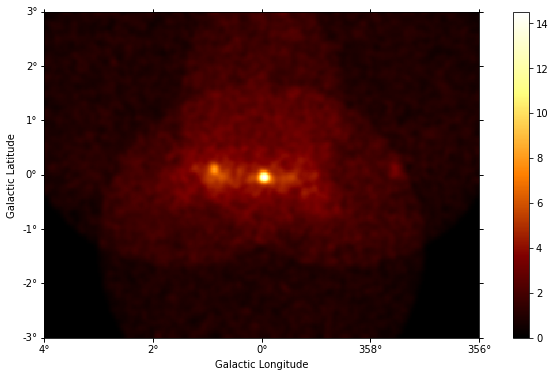

In [32]:
plt.figure(figsize=(12, 6))
counts_image = dataset_cta.counts.sum_over_axes()
counts_image.smooth("0.05 deg").plot(stretch="linear", add_cbar=True);

### Estimator Configuration

In [33]:
model = SkyModel(
    spectral_model=PowerLawSpectralModel(),
    spatial_model=PointSpatialModel()
)

map_estimator = TSMapEstimator(
    model=model,
    energy_edges=[0.1, 0.3, 1, 3, 10] * u.TeV,
    n_sigma=1,
    n_sigma_ul=2,
    selection_optional=None,
    n_jobs=8,
    kernel_width=1 * u.deg,
    sum_over_energy_groups=True
)

In [34]:
print(map_estimator)

TSMapEstimator
--------------

  downsampling_factor    : None
  energy_edges           : [ 0.1  0.3  1.   3.  10. ] TeV
  kernel_width           : 1.0 deg
  model                  : SkyModel
  n_jobs                 : 8
  n_sigma                : 1
  n_sigma_ul             : 2
  rtol                   : 0.01
  selection_optional     : []
  sum_over_energy_groups : True
  threshold              : None



In [35]:
%%time
map_result = map_estimator.run(dataset=dataset_cta)

CPU times: user 2.9 s, sys: 589 ms, total: 3.49 s
Wall time: 18.6 s


### Accessing and Visualising Results

In [36]:
print(map_result)

FluxMaps
--------

  geom                   : WcsGeom
  axes                   : ['lon', 'lat', 'energy']
  shape                  : (320, 240, 4)
  quantities             : ['ts', 'norm', 'niter', 'norm_err', 'npred', 'npred_excess', 'stat', 'stat_null', 'success']
  ref. model             : pl
  n_sigma                : 1
  n_sigma_ul             : 2
  sqrt_ts_threshold_ul   : 2
  sed type init          : None



In [37]:
type(map_result.dnde)

gammapy.maps.wcs.ndmap.WcsNDMap

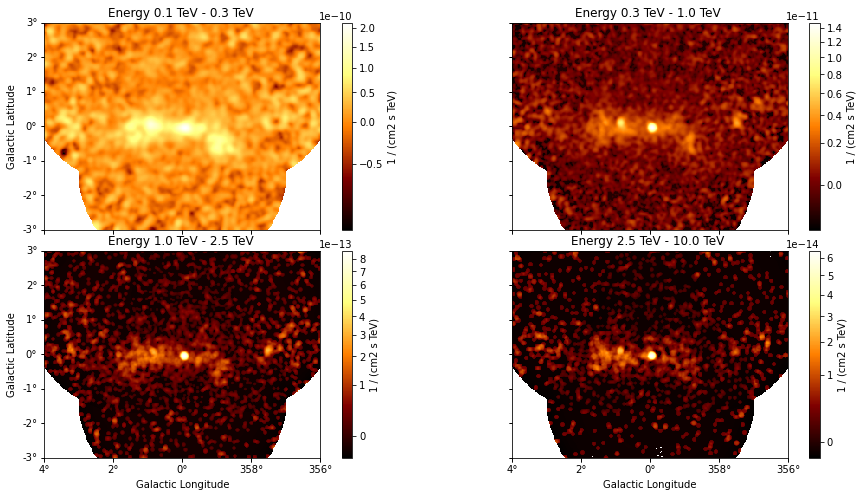

In [38]:
map_result.dnde.plot_grid(stretch="sqrt", ncols=2, add_cbar=True, figsize=(16, 8));

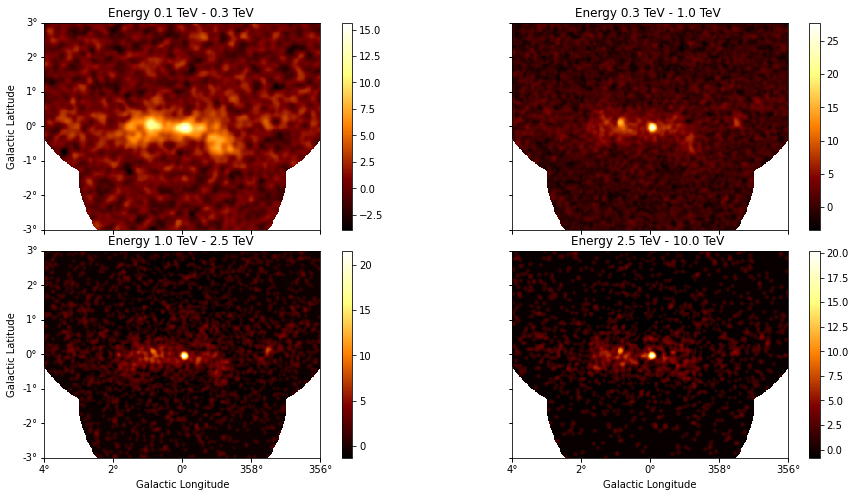

In [39]:
map_result.sqrt_ts.plot_grid(add_cbar=True, ncols=2, figsize=(16, 8));

Again the data is represented internally by a reference model and "norm" factors:

In [40]:
print(map_result.reference_model)

SkyModel

  Name                      : 15Z52e50
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                   :      2.000   +/-    0.00             
    amplitude               :   1.00e-12   +/- 0.0e+00 1 / (cm2 s TeV)
    reference    (frozen)   :      1.000       TeV         
    lon_0                   :      0.000   +/-    0.00 deg         
    lat_0                   :      0.000   +/-    0.00 deg         




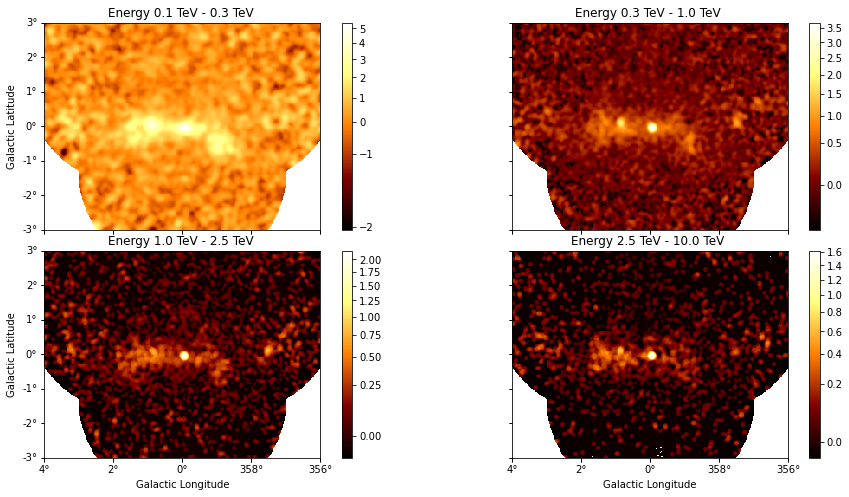

In [41]:
map_result.norm.plot_grid(add_cbar=True, ncols=2, stretch="sqrt", figsize=(16, 8));

In [42]:
position = SkyCoord("0d", "0d", frame="galactic")
flux_points = map_result.get_flux_points(position=position)

In [43]:
print(flux_points)

FluxPoints
----------

  geom                   : RegionGeom
  axes                   : ['lon', 'lat', 'energy']
  shape                  : (1, 1, 4)
  quantities             : ['ts', 'norm', 'niter', 'norm_err', 'npred', 'npred_excess', 'stat', 'stat_null', 'success']
  ref. model             : pl
  n_sigma                : 1
  n_sigma_ul             : 2
  sqrt_ts_threshold_ul   : 2
  sed type init          : None



<AxesSubplot:xlabel='Energy [TeV]', ylabel='e2dnde (erg / (cm2 s))'>

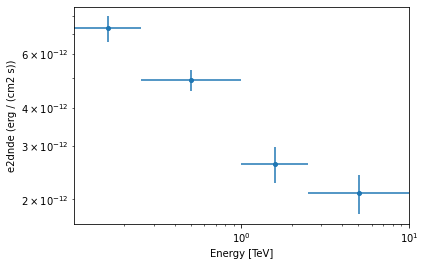

In [44]:
flux_points.plot(sed_type="e2dnde")

This is how the maps are serialised to FITS:

In [45]:
hdulist = map_result.to_hdulist(sed_type="dnde")
hdulist.info()

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       5   ()      
  1  DNDE          1 ImageHDU        29   (320, 240, 4)   float64   
  2  DNDE_BANDS    1 BinTableHDU     22   4R x 4C   ['K', 'D', 'D', 'D']   
  3  DNDE_ERR      1 ImageHDU        29   (320, 240, 4)   float64   
  4  DNDE_ERR_BANDS    1 BinTableHDU     22   4R x 4C   ['K', 'D', 'D', 'D']   
  5  TS            1 ImageHDU        29   (320, 240, 4)   float64   
  6  TS_BANDS      1 BinTableHDU     22   4R x 4C   ['K', 'D', 'D', 'D']   
  7  SQRT_TS       1 ImageHDU        29   (320, 240, 4)   float64   
  8  SQRT_TS_BANDS    1 BinTableHDU     22   4R x 4C   ['K', 'D', 'D', 'D']   
  9  NPRED         1 ImageHDU        29   (320, 240, 4)   float64   
 10  NPRED_BANDS    1 BinTableHDU     22   4R x 4C   ['K', 'D', 'D', 'D']   
 11  NPRED_EXCESS    1 ImageHDU        29   (320, 240, 4)   float64   
 12  NPRED_EXCESS_BANDS    1 BinTa

## Example 3: Flux Profiles (optional)

Finally we take a quick look at the newly introduced `FluxProfileEstimator`. For this we first define the profile bins as a list of `Region` objects:

In [46]:
regions = make_orthogonal_rectangle_sky_regions(
    start_pos=SkyCoord("2d", "0d", frame="galactic"),
    end_pos=SkyCoord("358d", "0d", frame="galactic"),
    wcs=counts_image.geom.wcs,
    height="1 deg",
    nbin=31,
)

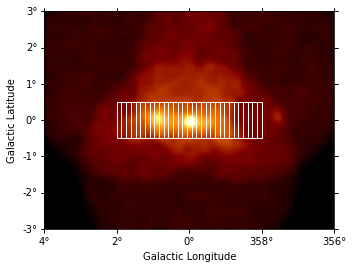

In [47]:
geom = RegionGeom.create(region=regions)
ax = counts_image.smooth("0.1 deg").plot()
geom.plot_region(ax=ax, color="w");

In [48]:
flux_profile_estimator = FluxProfileEstimator(
    regions=regions,
    spectrum=PowerLawSpectralModel(index=2.3),
    energy_edges=[0.1, 0.3, 1, 3, 10] * u.TeV,
    selection_optional="all",
)

In [49]:
%%time
profile = flux_profile_estimator.run(datasets=dataset_cta)

CPU times: user 28.7 s, sys: 453 ms, total: 29.2 s
Wall time: 29.9 s


In [50]:
print(profile)

FluxPoints
----------

  geom                   : RegionGeom
  axes                   : ['lon', 'lat', 'energy', 'projected-distance']
  shape                  : (1, 1, 4, 31)
  quantities             : ['norm', 'norm_err', 'norm_errn', 'norm_errp', 'norm_ul', 'ts', 'npred', 'npred_excess', 'stat', 'counts', 'success', 'stat_scan']
  ref. model             : pl
  n_sigma                : 1
  n_sigma_ul             : 2
  sqrt_ts_threshold_ul   : 2
  sed type init          : likelihood



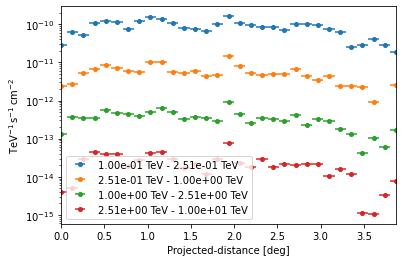

In [51]:
ax = profile.dnde.plot(axis_name="projected-distance")
ax.set_yscale("log")

<AxesSubplot:xlabel='Projected-distance [deg]', ylabel='$\\mathrm{}$'>

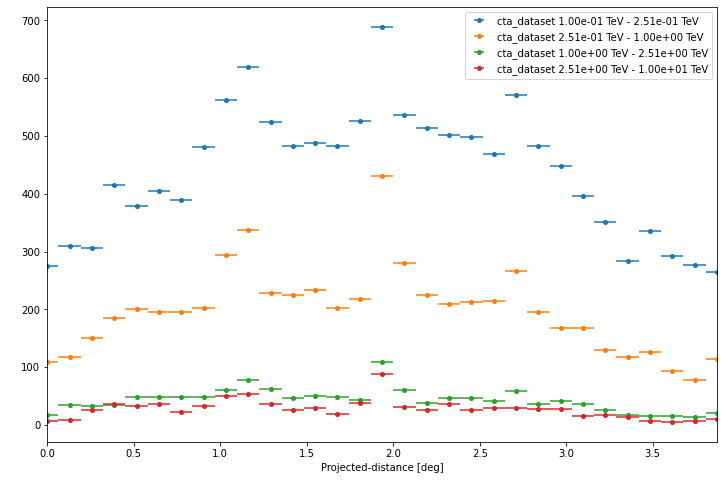

In [52]:
plt.figure(figsize=(12, 8))
profile.counts.plot(axis_name="projected-distance")

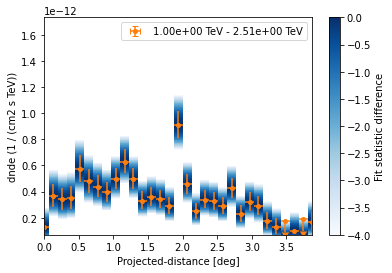

In [53]:
profile_3_10_TeV = profile.slice_by_idx({"energy": slice(2, 3)})
ax = profile_3_10_TeV.plot(sed_type="dnde", color="tab:orange")
profile_3_10_TeV.plot_ts_profiles(sed_type="dnde")
ax.set_yscale("linear")

(2e-12, 1e-11)

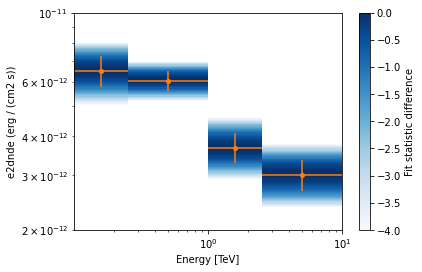

In [54]:
sed = profile.slice_by_idx({"projected-distance": 15})
ax = sed.plot(sed_type="e2dnde", color="tab:orange")
sed.plot_ts_profiles(ax=ax, sed_type="e2dnde")
ax.set_ylim(2e-12, 1e-11)

In [55]:
table = profile_3_10_TeV.to_table(sed_type="flux", format="profile")
table

x_min,x_max,x_ref,e_ref [1],e_min [1],e_max [1],flux [1],flux_err [1],flux_errp [1],flux_errn [1],flux_ul [1],ts [1],sqrt_ts [1],"npred [1,1]","npred_excess [1,1]",stat [1],is_ul [1],"counts [1,1]",success [1],"norm_scan [1,11]","stat_scan [1,11]"
deg,deg,deg,TeV,TeV,TeV,1 / (cm2 s),1 / (cm2 s),1 / (cm2 s),1 / (cm2 s),1 / (cm2 s),,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,bool,float64,bool,float64,float64
-0.06451612903225812,0.06451612903225812,0.0,1.5848931693527828,1.0,2.5118863582611084,2.0042602005533057e-13,9.642345197920391e-14,1.0464890882023487e-13,8.85036094928704e-14,4.2671760946653357e-13,6.920344112615737,2.630654692774355,17.455318196184734,8.462716,-38.34656355404696,False,17.0,True,0.2 .. 4.999999999999999,-37.2288506831267 .. 104.78137734403725
0.06451612903225812,0.19354838709677424,0.12903225806451618,1.5848931693527828,1.0,2.5118863582611084,5.682620828417051e-13,1.357275406042839e-13,1.436839647254917e-13,1.2800028321364162e-13,8.719748710273194e-13,38.51976934129985,6.206429677463513,33.39936478282661,24.324368,-125.09149228748004,False,34.0,True,0.2 .. 4.999999999999999,-105.0263823151534 .. -32.09609697343234
0.19354838709677424,0.32258064516129026,0.25806451612903225,1.5848931693527828,1.0,2.5118863582611084,5.258890560255263e-13,1.3213371635444742e-13,1.4002146407537475e-13,1.2451263834920036e-13,8.222078128453555e-13,33.19986479083977,5.761932383397064,31.921421813233096,22.774609,-119.84765644934663,False,33.0,True,0.2 .. 4.999999999999999,-103.10542402744215 .. -21.432727191084098
0.32258064516129026,0.4516129032258063,0.38709677419354827,1.5848931693527828,1.0,2.5118863582611084,5.431457000850443e-13,1.3437997512625858e-13,1.4217254527539453e-13,1.2680530914028057e-13,8.434882966604158e-13,33.80076029644118,5.813842128613502,34.85423663815153,23.790848,-130.55224983653278,False,35.0,True,0.2 .. 4.999999999999999,-113.02692795904036 .. -33.9712393039387
0.4516129032258063,0.5806451612903225,0.5161290322580644,1.5848931693527828,1.0,2.5118863582611084,8.851887485593488e-13,1.550194308366903e-13,1.6260110034803335e-13,1.4761622809645548e-13,1.225891460293495e-12,90.30295115568887,9.50278649427045,48.86425218713411,39.49686,-208.93233290551842,False,48.0,True,0.2 .. 4.999999999999999,-154.07917139494464 .. -142.66663675021476
0.5806451612903225,0.7096774193548387,0.6451612903225806,1.5848931693527828,1.0,2.5118863582611084,7.421224068560195e-13,1.4046589072683665e-13,1.473511644699626e-13,1.337420340342552e-13,1.050901849883572e-12,66.84173465210372,8.175679461188759,46.93254749565956,36.519974,-209.57341791837374,False,48.0,True,0.2 .. 4.999999999999999,-170.23976652798353 .. -123.49032388371091
0.7096774193548387,0.8387096774193548,0.7741935483870968,1.5848931693527828,1.0,2.5118863582611084,6.770012474433702e-13,1.2824668532688807e-13,1.3454032378142105e-13,1.2209716991221692e-13,9.589418152433564e-13,66.83077166383947,8.175008970260489,47.929392649571895,36.469574,-209.15818646746362,False,48.0,True,0.2 .. 4.999999999999999,-171.772111973043 .. -105.97101014676682
0.8387096774193548,0.967741935483871,0.9032258064516129,1.5848931693527828,1.0,2.5118863582611084,6.124179637636244e-13,1.2031524815808387e-13,1.2616491923586612e-13,1.1459752472548016e-13,8.766974307448409e-13,57.8483632724203,7.605811151509108,47.89126634822206,35.51918,-216.25048264498562,False,49.0,True,0.2 .. 4.999999999999999,-184.85681598212923 .. -97.16784251175065
